In [7]:
# Imports
import sys
sys.path.append('..')  # Add parent directory to path

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# yfinance fix für Yahoo Finance Rate Limiting
import yfinance_fix

# Our modules
from tradbot.portfolio import (
    calculate_expected_returns,
    calculate_covariance_matrix,
    optimize_max_sharpe,
    optimize_min_volatility,
    get_efficient_frontier
)
from tradbot.risk import (
    calculate_sharpe_ratio,
    calculate_max_drawdown,
    calculate_var
)

[yfinance_fix] Patch erfolgreich angewendet.
[yfinance_fix] Chrome-Session erstellt.


In [8]:
# Tickers auswählen
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']

# Historische Preise laden (2 Jahre) - mit chrome_session für Rate Limiting
prices = yf.download(tickers, period='2y', session=yfinance_fix.chrome_session)['Close']
prices.head()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2024-01-23,193.353989,156.020004,145.937363,382.527954,393.039825
2024-01-24,192.680344,156.869995,147.584869,387.989777,396.646057
2024-01-25,192.353409,157.750000,150.731094,390.452576,398.922119
2024-01-26,190.619781,159.119995,151.048706,391.405914,397.995941
2024-01-29,189.936234,161.259995,152.358810,398.238129,403.700867


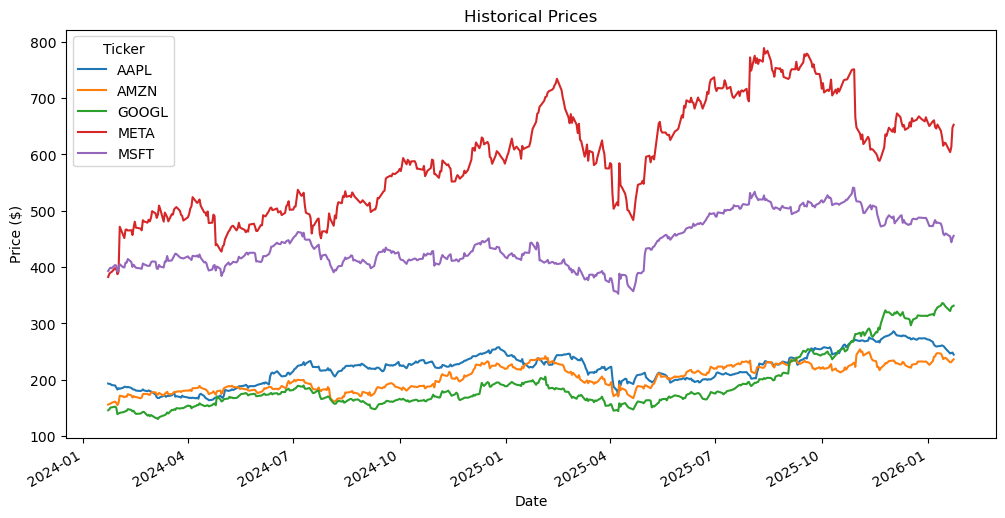

In [9]:
# Quick check: Preise plotten
prices.plot(figsize=(12, 6), title='Historical Prices')
plt.ylabel('Price ($)')
plt.show()

In [10]:
# Expected Returns berechnen
mu = calculate_expected_returns(prices)
print("Expected Annual Returns:")
print(mu.sort_values(ascending=False))

Expected Annual Returns:
Ticker
GOOGL    0.509691
META     0.307658
AMZN     0.231793
AAPL     0.125670
MSFT     0.076763
dtype: float64


In [11]:
# Covariance Matrix
S = calculate_covariance_matrix(prices)
print("Covariance Matrix:")
S

Covariance Matrix:


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Ticker,,,,,
AAPL,0.077620,0.041486,0.037103,0.038841,0.029135
AMZN,0.041486,0.099646,0.050669,0.073929,0.043937
GOOGL,0.037103,0.050669,0.091586,0.046450,0.031863
META,0.038841,0.073929,0.046450,0.139986,0.050978
MSFT,0.029135,0.043937,0.031863,0.050978,0.049930


In [12]:
# Maximum Sharpe Ratio Portfolio
weights_sharpe, perf_sharpe = optimize_max_sharpe(prices)

print("=== MAX SHARPE PORTFOLIO ===")
print("\nWeights:")
for ticker, weight in weights_sharpe.items():
    if weight > 0.01:  # Nur Gewichte > 1% anzeigen
        print(f"  {ticker}: {weight:.2%}")

print(f"\nPerformance:")
print(f"  Expected Return: {perf_sharpe[0]:.2%}")
print(f"  Volatility:      {perf_sharpe[1]:.2%}")
print(f"  Sharpe Ratio:    {perf_sharpe[2]:.2f}")

=== MAX SHARPE PORTFOLIO ===

Weights:
  GOOGL: 93.88%
  META: 6.12%

Performance:
  Expected Return: 49.73%
  Volatility:      29.42%
  Sharpe Ratio:    1.62


In [13]:
# Minimum Volatility Portfolio
weights_minvol, perf_minvol = optimize_min_volatility(prices)

print("=== MIN VOLATILITY PORTFOLIO ===")
print("\nWeights:")
for ticker, weight in weights_minvol.items():
    if weight > 0.01:
        print(f"  {ticker}: {weight:.2%}")

print(f"\nPerformance:")
print(f"  Expected Return: {perf_minvol[0]:.2%}")
print(f"  Volatility:      {perf_minvol[1]:.2%}")
print(f"  Sharpe Ratio:    {perf_minvol[2]:.2f}")

=== MIN VOLATILITY PORTFOLIO ===

Weights:
  AAPL: 24.35%
  GOOGL: 15.08%
  MSFT: 60.57%

Performance:
  Expected Return: 15.39%
  Volatility:      20.53%
  Sharpe Ratio:    0.65


In [14]:
# Efficient Frontier berechnen
frontier = get_efficient_frontier(prices, n_points=50)
frontier.head()

ValueError: target_return must be lower than the maximum possible return

In [ ]:
# Plot Efficient Frontier
plt.figure(figsize=(10, 7))

# Efficient Frontier Kurve
plt.plot(
    frontier['volatility'] * 100, 
    frontier['return'] * 100, 
    'b-', 
    linewidth=2, 
    label='Efficient Frontier'
)

# Max Sharpe Portfolio (roter Stern)
plt.scatter(
    perf_sharpe[1] * 100, 
    perf_sharpe[0] * 100, 
    marker='*', 
    s=300, 
    c='red', 
    label=f'Max Sharpe (SR={perf_sharpe[2]:.2f})'
)

# Min Volatility Portfolio (grüner Punkt)
plt.scatter(
    perf_minvol[1] * 100, 
    perf_minvol[0] * 100, 
    marker='o', 
    s=200, 
    c='green', 
    label='Min Volatility'
)

# Individual Assets (graue Punkte)
individual_returns = mu * 100
individual_vols = np.sqrt(np.diag(S)) * 100
plt.scatter(
    individual_vols, 
    individual_returns, 
    marker='o', 
    s=100, 
    c='gray', 
    alpha=0.5,
    label='Individual Assets'
)

# Asset Labels
for i, ticker in enumerate(tickers):
    plt.annotate(
        ticker, 
        (individual_vols[i], individual_returns[i]),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

plt.xlabel('Volatility (%)', fontsize=12)
plt.ylabel('Expected Return (%)', fontsize=12)
plt.title('Efficient Frontier', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Bar Chart: Weights Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Max Sharpe Weights
weights_df_sharpe = pd.Series(weights_sharpe)
weights_df_sharpe = weights_df_sharpe[weights_df_sharpe > 0.01]
axes[0].bar(weights_df_sharpe.index, weights_df_sharpe.values * 100, color='red', alpha=0.7)
axes[0].set_title('Max Sharpe Portfolio')
axes[0].set_ylabel('Weight (%)')
axes[0].tick_params(axis='x', rotation=45)

# Min Volatility Weights
weights_df_minvol = pd.Series(weights_minvol)
weights_df_minvol = weights_df_minvol[weights_df_minvol > 0.01]
axes[1].bar(weights_df_minvol.index, weights_df_minvol.values * 100, color='green', alpha=0.7)
axes[1].set_title('Min Volatility Portfolio')
axes[1].set_ylabel('Weight (%)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Daily Returns berechnen
returns = prices.pct_change().dropna()

# Portfolio Returns (mit Max Sharpe Weights)
portfolio_returns = (returns * pd.Series(weights_sharpe)).sum(axis=1)

# Portfolio Prices (für Drawdown)
portfolio_prices = (1 + portfolio_returns).cumprod() * 100  # Start bei 100

print("=== RISK METRICS (Max Sharpe Portfolio) ===")
print(f"Sharpe Ratio:    {calculate_sharpe_ratio(portfolio_returns):.2f}")
print(f"Max Drawdown:    {calculate_max_drawdown(portfolio_prices):.2%}")
print(f"VaR (95%):       {calculate_var(portfolio_returns, 0.95):.2%}")

In [ ]:
# Portfolio Value über Zeit
plt.figure(figsize=(12, 5))
portfolio_prices.plot()
plt.title('Portfolio Value (Max Sharpe)')
plt.ylabel('Value ($)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.show()